In [1]:
import os
import gc
import re

import datetime

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')
%matplotlib inline
%config InlineBackend.figure_formats = {'png', 'retina'}

from scipy.stats import linregress

import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing

from tqdm import tqdm_notebook as tqdm

import warnings
warnings.filterwarnings('ignore')

-----

## 検証スペース

In [8]:
calendar = pd.read_pickle('../data/reduced/calendar.pkl')

calendar[['wm_yr_wk', '']]

In [10]:
dst_df = parse_sell_price(df)

KeyError: 'month'

---------

## Objectives

- [ ] Baselineを作る。
    - 簡単な特徴量エンジニアリングを行う。
- [ ] TimeSeriesSplitを使ったCVを行う。
- [ ] 予測精度の評価を行う。

## Note

- Validation のラベルデータが配られたら、validation.csvと結合して、trainデータを増やす。

## Scores

## Load Data

In [2]:
def read_data():
    files = ['calendar', 'sample_submission', 'sales_train_validation', 'sell_prices']

    if os.path.exists('/kaggle/input/m5-forecasting-accuracy'):
        data_dir_path = '/kaggle/input/m5-forecasting-accuracy'
        dst_data = {}
        for file in files:
            print(f'Reading {file} ....')
            dst_data[file] = pd.read_csv(data_dir_path + file + '.csv')
    else:
        data_dir_path = '../data/reduced/'
        dst_data = {}
        for file in files:
            print(f'Reading {file} ....')
            dst_data[file] = pd.read_pickle(data_dir_path + file + '.pkl')
    return dst_data.values()

In [3]:
calendar, submission, train, sell_prices = read_data()
test = train.sample(10000).copy(deep=True)

Reading calendar ....
Reading sample_submission ....
Reading sales_train_validation ....
Reading sell_prices ....


In [4]:
print('calendar')
print(calendar.shape)
display(calendar.head())

print('submission')
print(submission.shape)
display(submission.head())

print('train')
print(train.shape)
display(train.head())

print('sell_prices')
print(sell_prices.shape)
display(sell_prices.head())

print('test')
print(test.shape)
display(test.head())

calendar
(1969, 14)


,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1


submission
(60980, 29)


,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,HOBBIES_1_001_CA_1_validation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,HOBBIES_1_002_CA_1_validation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,HOBBIES_1_004_CA_1_validation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,HOBBIES_1_005_CA_1_validation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


train
(30490, 1919)


,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,2,1,1,1,0,1,1,1
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,5,4,1,0,1,3,7,2
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,1,0,1,1,2,2,2,4


sell_prices
(6841121, 4)


,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325,9.578125
1,CA_1,HOBBIES_1_001,11326,9.578125
2,CA_1,HOBBIES_1_001,11327,8.257812
3,CA_1,HOBBIES_1_001,11328,8.257812
4,CA_1,HOBBIES_1_001,11329,8.257812


test
(10000, 1919)


,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
10351,HOUSEHOLD_2_108_CA_4_validation,HOUSEHOLD_2_108,HOUSEHOLD_2,HOUSEHOLD,CA_4,CA,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
17086,FOODS_2_014_TX_2_validation,FOODS_2_014,FOODS_2,FOODS,TX_2,TX,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
2066,FOODS_2_240_CA_1_validation,FOODS_2_240,FOODS_2,FOODS,CA_1,CA,4,0,2,2,...,0,0,0,0,0,0,0,0,0,0
30281,FOODS_3_616_WI_3_validation,FOODS_3_616,FOODS_3,FOODS,WI_3,WI,3,3,1,0,...,1,1,5,1,1,1,1,1,1,1
1060,HOUSEHOLD_1_505_CA_1_validation,HOUSEHOLD_1_505,HOUSEHOLD_1,HOUSEHOLD,CA_1,CA,0,0,0,0,...,2,2,1,2,2,3,0,2,4,0


### Preprocess Data Transform

In [5]:
# MEMO: 予測日数分のデータをtrain/testに水平結合する。
def hstack_sales_colums(df, last_d, stack_days=28):
    add_columns = ['d_'+str(i+1) for i in range(last_d, train_last_d+stack_days)]
    add_df = pd.DataFrame(index=df.index, columns=add_columns).fillna(0)
    return pd.concat([df, add_df], axis=1)


train_last_d = 1913
test_last_d = 1913
    
train = hstack_sales_colums(train, train_last_d)
test = hstack_sales_colums(train, test_last_d)

In [6]:
def reduce_mem_usage(df, verbose=True):
    numerics = ["int16", "int32", "int64", "float16", "float32", "float64"]
    start_mem = df.memory_usage().sum() / 1024 ** 2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == "int":
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024 ** 2
    if verbose:
        print(
            "Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)".format(
                end_mem, 100 * (start_mem - end_mem) / start_mem
            )
        )
    return df

In [7]:
def encode_calendar(df, filename='encoded_calendar', use_cache=True):
    filepath = f'features/{filename}.pkl'
    if use_cache and os.path.exists(filepath):
        return pd.read_pickle(filepath)

    # Drop Columns
    cols_to_drop = ['weekday', 'wday', 'year']
    df.drop(cols_to_drop, axis=1, inplace=True)
    # Parse Date Feature
    dt_col = 'date'
    df[dt_col] = pd.to_datetime(df[dt_col])
    attrs = [
        "quarter",
        "month",
        "week",
        "day",
        "dayofweek",
        "is_year_end",
        "is_year_start",
        "is_quarter_end",
        "is_quarter_start",
        "is_month_end",
        "is_month_start",
    ]
    for attr in attrs:
        dtype = np.int16 if attr == "year" else np.int8
        df[attr] = getattr(df[dt_col].dt, attr).astype(dtype)

    df["is_weekend"] = df["dayofweek"].isin([5, 6]).astype(np.int8)
    # MEMO: N_Unique of event_name_1 == 31 and event_name_2 == 5.
    event_cols = ['event_name_1', 'event_type_1', 'event_name_2', 'event_type_2']
    df[event_cols] = df[event_cols].fillna('None')
    for c in event_cols:
        le = preprocessing.LabelEncoder()
        df[c] = le.fit_transform(df[c].values).astype('int8')
    df.to_pickle(filepath)
    return df

In [8]:
# MEMO:
# - 数値の値が入っていない Column は、['date', 'd']
calendar = encode_calendar(calendar, use_cache=True)

In [9]:
def melt_data(df, calendar, sell_prices, encode_maps, filename, use_cache=True):
    filepath = f'features/{filename}.pkl'
    if use_cache and os.path.exists(filepath):
        return pd.read_pickle(filepath)
    # MEMO: ラベルは全データ共通なので、train/test/sell_prices の LabelEncode に使える。
    for label, encode_map in encode_maps.items():
        df[label] = df[label].map(encode_map)
        if label in ['item_id', 'store_id']:
            sell_prices[label] = sell_prices[label].map(encode_map)
    # Melt Main Data and Join Optinal Data.
    id_columns = ['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id']
    df = pd.melt(df, id_vars=id_columns, var_name='d', value_name='sales')
    df = pd.merge(df, calendar, how='left', on='d')
    df = pd.merge(df, sell_prices, how='left', on=['store_id', 'item_id', 'wm_yr_wk'])
    # MEMO: sell_price を直近価格で過去の値を埋める。
    # - 値が入っていない商品はないが、値が入っていない週は存在する。
    # - 欠損値の原因は、欠品なのか、計測漏れなのか理由が定かでないので、安易に保管するのは危険。
    # - 様々な保管方法を試して、後で、Null Importanceで確かめるなどしたほうがよい。
    # - 上記の理由から、今は欠損値のまま扱う。
    # df['sell_price'] = df.groupby('item_id')['sell_price'].bfill()
    # Cache DataFrame.
    df = df.pipe(reduce_mem_usage)
    df.to_pickle(filepath)
    return df

In [10]:
encode_maps = {}
categorical_cols = ['item_id', 'dept_id', 'cat_id', 'store_id', 'state_id']
encode_maps = {col: {label: i for i, label in enumerate(sorted(train[col].unique()))}
                       for col in categorical_cols}

train = melt_data(train, calendar, sell_prices, encode_maps, filename='melted_train', use_cache=True)


# If you want to sample the data, delete the comment out below.
# n_sample_rows = 35_000_000 # TODO: 全体から何年分のデータを捨てる。みたいな選択方法にしたい。
# train = train.loc[n_sample_rows:]

In [11]:
print(train.shape)
train.head()

(59181090, 30)


,id,item_id,dept_id,cat_id,store_id,state_id,d,sales,date,wm_yr_wk,...,day,dayofweek,is_year_end,is_year_start,is_quarter_end,is_quarter_start,is_month_end,is_month_start,is_weekend,sell_price
0,HOBBIES_1_001_CA_1_validation,1437,3,1,0,0,d_1,0,2011-01-29,11101,...,29,5,0,0,0,0,0,0,1,NaN
1,HOBBIES_1_002_CA_1_validation,1438,3,1,0,0,d_1,0,2011-01-29,11101,...,29,5,0,0,0,0,0,0,1,NaN
2,HOBBIES_1_003_CA_1_validation,1439,3,1,0,0,d_1,0,2011-01-29,11101,...,29,5,0,0,0,0,0,0,1,NaN
3,HOBBIES_1_004_CA_1_validation,1440,3,1,0,0,d_1,0,2011-01-29,11101,...,29,5,0,0,0,0,0,0,1,NaN
4,HOBBIES_1_005_CA_1_validation,1441,3,1,0,0,d_1,0,2011-01-29,11101,...,29,5,0,0,0,0,0,0,1,NaN


## Feature Engineering

- shiftするだけの特徴量
- 予測日数shiftした後、rollingした統計情報
- calendarの情報
    - 翌日休日フラグ
        - CalendarShiftFeature
    - 連休日数
        - 翌日休日フラグを前後にshiftすればよさそう。
- 当該月の特徴量
    - 1日の売上
    - 7, 10, 15, 20日時点の累積売上
        - Calendarにデータを作って、groupby したほうがいいだろうなー。
- 過去１ヶ月での、スーパー全体の売上のうちの自分の売上の割合
    - 相対的にみてよく売れる商品ですよ。というのを言える。
        - てことは、個数で見たほうがいいかもしれない。

In [12]:
class BaseFeature():
    def __init__(self, filename, use_cache=True):
        self.filepath = f'features/{filename}.pkl'
        self.use_cache = use_cache
        self.is_exist_cahce = False
        self.df = pd.DataFrame()
        
    def __enter__(self):
        if self.use_cache:
            self.check_exist_cahce()
        return self

    def __exit__(self, exc_type, exc_value, traceback):
        if not self.is_exist_cahce:
            self.df.to_pickle(self.filepath)   # save_cache

    def check_exist_cahce(self):
        if os.path.exists(self.filepath):
            self.is_exist_cahce = True
    
    def get_feature(self, df):
        if self.is_exist_cahce:
            self.df = pd.read_pickle(self.filepath)
            return self.df
        else:
            self.df = self.create_feature(df)
            return self.df

    def create_feature(self, df):
        raise NotImplementedError

In [13]:
class AddSalesFeature(BaseFeature):
    def create_feature(self, df):
        DAYS_PRED = 28
        col = 'sales'
        grouped_df = df.groupby(["id"])[col]

        for diff in [0, 1, 2]:
            shift = DAYS_PRED + diff
            df[f"{col}_lag_t{shift}"] = grouped_df.transform(lambda x: x.shift(shift))

        for window in [7, 30, 60, 90, 180]:
            df[f"{col}_rolling_STD_t{window}"] = grouped_df.transform(lambda x: x.shift(DAYS_PRED).rolling(window).std())

        for window in [7, 30, 60, 90, 180]:
            df[f"{col}rolling_MEAN_t{window}"] = grouped_df.transform(lambda x: x.shift(DAYS_PRED).rolling(window).mean())

        for window in [7, 30, 60]:
            df[f"{col}rolling_MIN_t{window}"] = grouped_df.transform(lambda x: x.shift(DAYS_PRED).rolling(window).min())

        for window in [7, 30, 60]:
            df[f"{col}rolling_MAX_t{window}"] = grouped_df.transform(lambda x: x.shift(DAYS_PRED).rolling(window).max())

        df[f"{col}_rolling_SKEW_t30"] = grouped_df.transform(lambda x: x.shift(DAYS_PRED).rolling(30).skew())
        df[f"{col}_rolling_KURT_t30"] = grouped_df.transform(lambda x: x.shift(DAYS_PRED).rolling(30).kurt())
        return df

In [68]:
class AddPriceFeature(BaseFeature):
    def create_feature(self, df):
        DAYS_PRED = 28
        col = 'sell_price'
        grouped_df = df.groupby(["id"])[col]
        
        for diff in [0]:
            shift = DAYS_PRED + diff
            df[f"{col}_lag_t{shift}"] = grouped_df.transform(lambda x: x.shift(shift))
        
        df[f"{col}_rolling_price_MAX_t365"] = grouped_df.transform(lambda x: x.shift(DAYS_PRED).rolling(365).max())
        df[f"{col}_price_change_t365"] = \
            (df[f"{col}_rolling_price_MAX_t365"] - df["sell_price"]) / (df[f"{col}_rolling_price_MAX_t365"])
        
        df[f"{col}_rolling_price_std_t7"] = grouped_df.transform(lambda x: x.shift(DAYS_PRED).rolling(7).std())
        df[f"{col}_rolling_price_std_t30"] = grouped_df.transform(lambda x: x.shift(DAYS_PRED).rolling(30).std())
        return df.drop([f"{col}_rolling_price_MAX_t365"], axis=1)

In [70]:
class AddWeight(BaseFeature):
    def create_feature(self, df):
        grouped_df = df.groupby(["id"])['sales']
        df['weight'] = grouped_df.transform(lambda x: 1 - (x==0).rolling(28).mean())
        return df

In [71]:
with AddSalesFeature(filename='add_sales_train', use_cache=True) as feat:
    train = feat.get_feature(train).pipe(reduce_mem_usage)
    
with AddPriceFeature(filename='add_price_train', use_cache=True) as feat:
    train = feat.get_feature(train).pipe(reduce_mem_usage)

with AddWeight(filename='add_weight', use_cache=False) as feat:
    train = feat.get_feature(train).pipe(reduce_mem_usage)

Mem. usage decreased to 5926.15 Mb (0.0% reduction)
Mem. usage decreased to 6377.66 Mb (0.0% reduction)
Mem. usage decreased to 6490.54 Mb (5.0% reduction)


In [72]:
DAYS_PRED = 28
num_unique_id = train['id'].nunique()
max_roll_days = 180

skip_raws = num_unique_id * (max_roll_days + DAYS_PRED)
train = train.iloc[skip_raws:].reset_index(drop=True)

In [73]:
print(train.shape)
train.head()

(53692862, 56)


,id,item_id,dept_id,cat_id,store_id,state_id,d,sales,date,wm_yr_wk,...,salesrolling_MAX_t7,salesrolling_MAX_t30,salesrolling_MAX_t60,sales_rolling_SKEW_t30,sales_rolling_KURT_t30,sell_price_lag_t28,sell_price_price_change_t365,sell_price_rolling_price_std_t7,sell_price_rolling_price_std_t30,weight
0,HOBBIES_1_029_CA_1_validation,1465,3,1,0,0,d_181,1,2011-07-28,11126,...,4.0,7.0,7.0,1.113281,1.458008,7.441406,NaN,0.0,0.0,0.643066
1,HOBBIES_1_030_CA_1_validation,1466,3,1,0,0,d_181,0,2011-07-28,11126,...,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
2,HOBBIES_1_031_CA_1_validation,1467,3,1,0,0,d_181,1,2011-07-28,11126,...,0.0,1.0,1.0,1.328125,-0.257324,10.976562,NaN,0.0,0.0,0.571289
3,HOBBIES_1_032_CA_1_validation,1468,3,1,0,0,d_181,14,2011-07-28,11126,...,7.0,52.0,52.0,2.199219,4.000000,0.540039,NaN,0.0,0.0,0.893066
4,HOBBIES_1_033_CA_1_validation,1469,3,1,0,0,d_181,0,2011-07-28,11126,...,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.000000


## Training Model and Prediction

In [74]:
def plot_cv_indices(cv, X, y, dt_col, lw=10):
    n_splits = cv.get_n_splits()
    _, ax = plt.subplots(figsize=(20, n_splits))

    # Generate the training/testing visualizations for each CV split
    for ii, (tr, tt) in enumerate(cv.split(X=X, y=y)):
        # Fill in indices with the training/test groups
        indices = np.array([np.nan] * len(X))
        indices[tt] = 1
        indices[tr] = 0

        # Visualize the results
        ax.scatter(
            X[dt_col],
            [ii + 0.5] * len(indices),
            c=indices,
            marker="_",
            lw=lw,
            cmap=plt.cm.coolwarm,
            vmin=-0.2,
            vmax=1.2,
        )

    # Formatting
    MIDDLE = 15
    LARGE = 20
    ax.set_xlabel("Datetime", fontsize=LARGE)
    ax.set_xlim([X[dt_col].min(), X[dt_col].max()])
    ax.set_ylabel("CV iteration", fontsize=LARGE)
    ax.set_yticks(np.arange(n_splits) + 0.5)
    ax.set_yticklabels(list(range(n_splits)))
    ax.invert_yaxis()
    ax.tick_params(axis="both", which="major", labelsize=MIDDLE)
    ax.set_title("{}".format(type(cv).__name__), fontsize=LARGE)
    return ax

In [75]:
class CustomTimeSeriesSplitter:
    def __init__(self, n_splits=5, train_days=80, test_days=20, dt_col="date"):
        self.n_splits = n_splits
        self.train_days = train_days
        self.test_days = test_days
        self.dt_col = dt_col

    def split(self, X, y=None, groups=None):
        sec = (X[self.dt_col] - X[self.dt_col][0]).dt.total_seconds()
        duration = sec.max() - sec.min()

        train_sec = 3600 * 24 * self.train_days
        test_sec = 3600 * 24 * self.test_days
        total_sec = test_sec + train_sec
        step = (duration - total_sec) / (self.n_splits - 1)

        for idx in range(self.n_splits):
            train_start = idx * step
            train_end = train_start + train_sec
            test_end = train_end + test_sec

            if idx == self.n_splits - 1:
                test_mask = sec >= train_end
            else:
                test_mask = (sec >= train_end) & (sec < test_end)

            train_mask = (sec >= train_start) & (sec < train_end)
            test_mask = (sec >= train_end) & (sec < test_end)

            yield sec[train_mask].index.values, sec[test_mask].index.values

    def get_n_splits(self):
        return self.n_splits

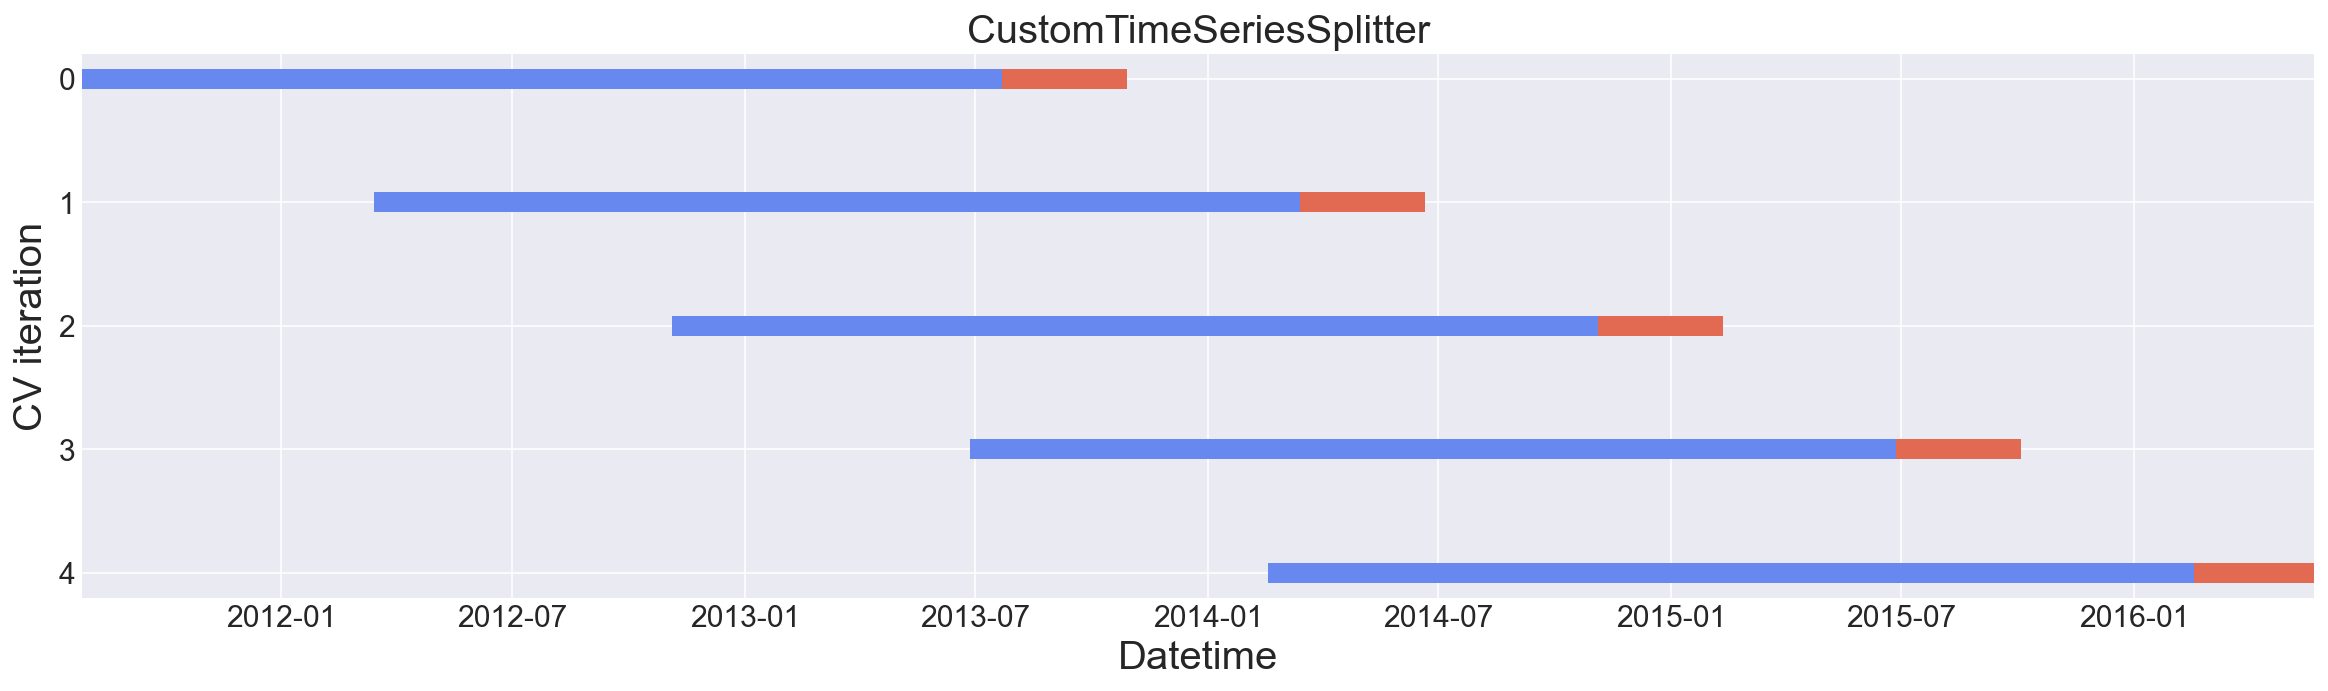

In [76]:
cv_params = {
    "n_splits": 5,
    "train_days": 365 * 2,
    "test_days": 28,
    "dt_col": 'date',
}
cv = CustomTimeSeriesSplitter(**cv_params)
# Plotting all the points takes long time.
plot_cv_indices(cv, train.iloc[::1000][['date']].reset_index(drop=True), None, 'date')

In [77]:
target_col = 'sales'

features = train.columns.tolist()
cols_to_drop = ['id', 'wm_yr_wk', 'd', 'date'] + [target_col]

features = [f for f in features if f not in cols_to_drop]

In [78]:
PRED_INTERVAL = 28
latest_date = train['date'].max()
submit_date = latest_date - datetime.timedelta(days=PRED_INTERVAL)
submit_mask = (train["date"] > submit_date)

eval_date = latest_date - datetime.timedelta(days=PRED_INTERVAL*2)
eval_mask = ((train["date"] > eval_date) & (train["date"] <= submit_date))

train_mask = ((~eval_mask) & (~submit_mask))

X_train, y_train = train[train_mask][['date'] + features], train[train_mask][target_col]
X_eval, y_eval = train[eval_mask][['date'] + features], train[eval_mask][target_col]
X_submit, y_submit = train[submit_mask][['date'] + features], train[submit_mask][target_col]

In [79]:
def rmsele(preds, actual, weight=None):
    return mean_squared_error(np.log1p(actual), np.log1p(preds), sample_weight=weight, squared=False)

def rmsle(preds, data):
    weight = data.get_weight()
    return 'RMSLE', rmsele(preds, data.get_label(), weight), False

def train_lgb(bst_params, fit_params, X, y, cv, drop_when_train=None):
    models = []

    if drop_when_train is None:
        drop_when_train = []

    for idx_fold, (idx_trn, idx_val) in enumerate(cv.split(X, y)):
        print(f"\n---------- Fold: ({idx_fold + 1} / {cv.get_n_splits()}) ----------\n")

        X_trn, X_val = X.iloc[idx_trn], X.iloc[idx_val]
        y_trn, y_val = y.iloc[idx_trn], y.iloc[idx_val]
        train_set = lgb.Dataset(X_trn.drop(drop_when_train, axis=1), label=y_trn, weight=X_trn['weight'])
        val_set = lgb.Dataset(X_val.drop(drop_when_train, axis=1), label=y_val, weight=X_val['weight'])

        model = lgb.train(
            bst_params,
            train_set,
            valid_sets=[train_set, val_set],
            valid_names=["train", "valid"],
            **fit_params,
            feval=rmsle,
        )
        models.append(model)

        del idx_trn, idx_val, X_trn, X_val, y_trn, y_val
        gc.collect()

    return models

In [80]:
bst_params = {
    "boosting_type": "gbdt",
    "metric": "None", # "rmse",
    "objective": "poisson",
    "seed": 11,
    "learning_rate": 0.3,
    'max_depth': 9,
    'min_data_in_leaf': 50,
    "bagging_fraction": 0.8,
    "bagging_freq": 10,
    "feature_fraction": 0.8,
}

fit_params = {
    "num_boost_round": 100_000,
    "early_stopping_rounds": 50,
    "verbose_eval": 100,
}

models = train_lgb(
    bst_params, fit_params, X_train, y_train, cv, drop_when_train=['date', 'weight']
)

del X_train, y_train; gc.collect()


---------- Fold: (1 / 5) ----------

Training until validation scores don't improve for 50 rounds
[100]	train's RMSLE: 0.649067	valid's RMSLE: 0.650793
[200]	train's RMSLE: 0.644702	valid's RMSLE: 0.649347
[300]	train's RMSLE: 0.641905	valid's RMSLE: 0.649254
[400]	train's RMSLE: 0.640036	valid's RMSLE: 0.647853
[500]	train's RMSLE: 0.638671	valid's RMSLE: 0.647973
Early stopping, best iteration is:
[471]	train's RMSLE: 0.639036	valid's RMSLE: 0.647732

---------- Fold: (2 / 5) ----------

Training until validation scores don't improve for 50 rounds
[100]	train's RMSLE: 0.647768	valid's RMSLE: 0.645663
[200]	train's RMSLE: 0.644032	valid's RMSLE: 0.643147
[300]	train's RMSLE: 0.641453	valid's RMSLE: 0.641079
[400]	train's RMSLE: 0.639808	valid's RMSLE: 0.640226
[500]	train's RMSLE: 0.638203	valid's RMSLE: 0.63974
[600]	train's RMSLE: 0.637056	valid's RMSLE: 0.639482
[700]	train's RMSLE: 0.635834	valid's RMSLE: 0.639008
[800]	train's RMSLE: 0.634819	valid's RMSLE: 0.638631
[900]	train'

0

In [81]:
def get_feature_importance(models):
    feature_importance = pd.DataFrame(
        [model.feature_importance() for model in models],
        columns=models[0].feature_name()
    ).T

    feature_importance['Agerage_Importance'] = feature_importance.iloc[:, :len(models)].mean(axis=1)
    feature_importance['importance_std'] = feature_importance.iloc[:, :len(models)].std(axis=1)
    feature_importance.sort_values(by='Agerage_Importance', inplace=True)
    return feature_importance

def plot_importance(models, max_num_features=50, figsize=(12, 15)):
    feature_importance = get_feature_importance(models)
    plt.figure(figsize=figsize)

    feature_importance[-max_num_features:].plot(
        kind='barh', title='Feature importance', figsize=figsize,
        y='Agerage_Importance', xerr='importance_std',
        grid=True, align="center"
    )
    plt.legend()
    plt.savefig('figure/importance.png')
    plt.show()

<Figure size 864x1080 with 0 Axes>

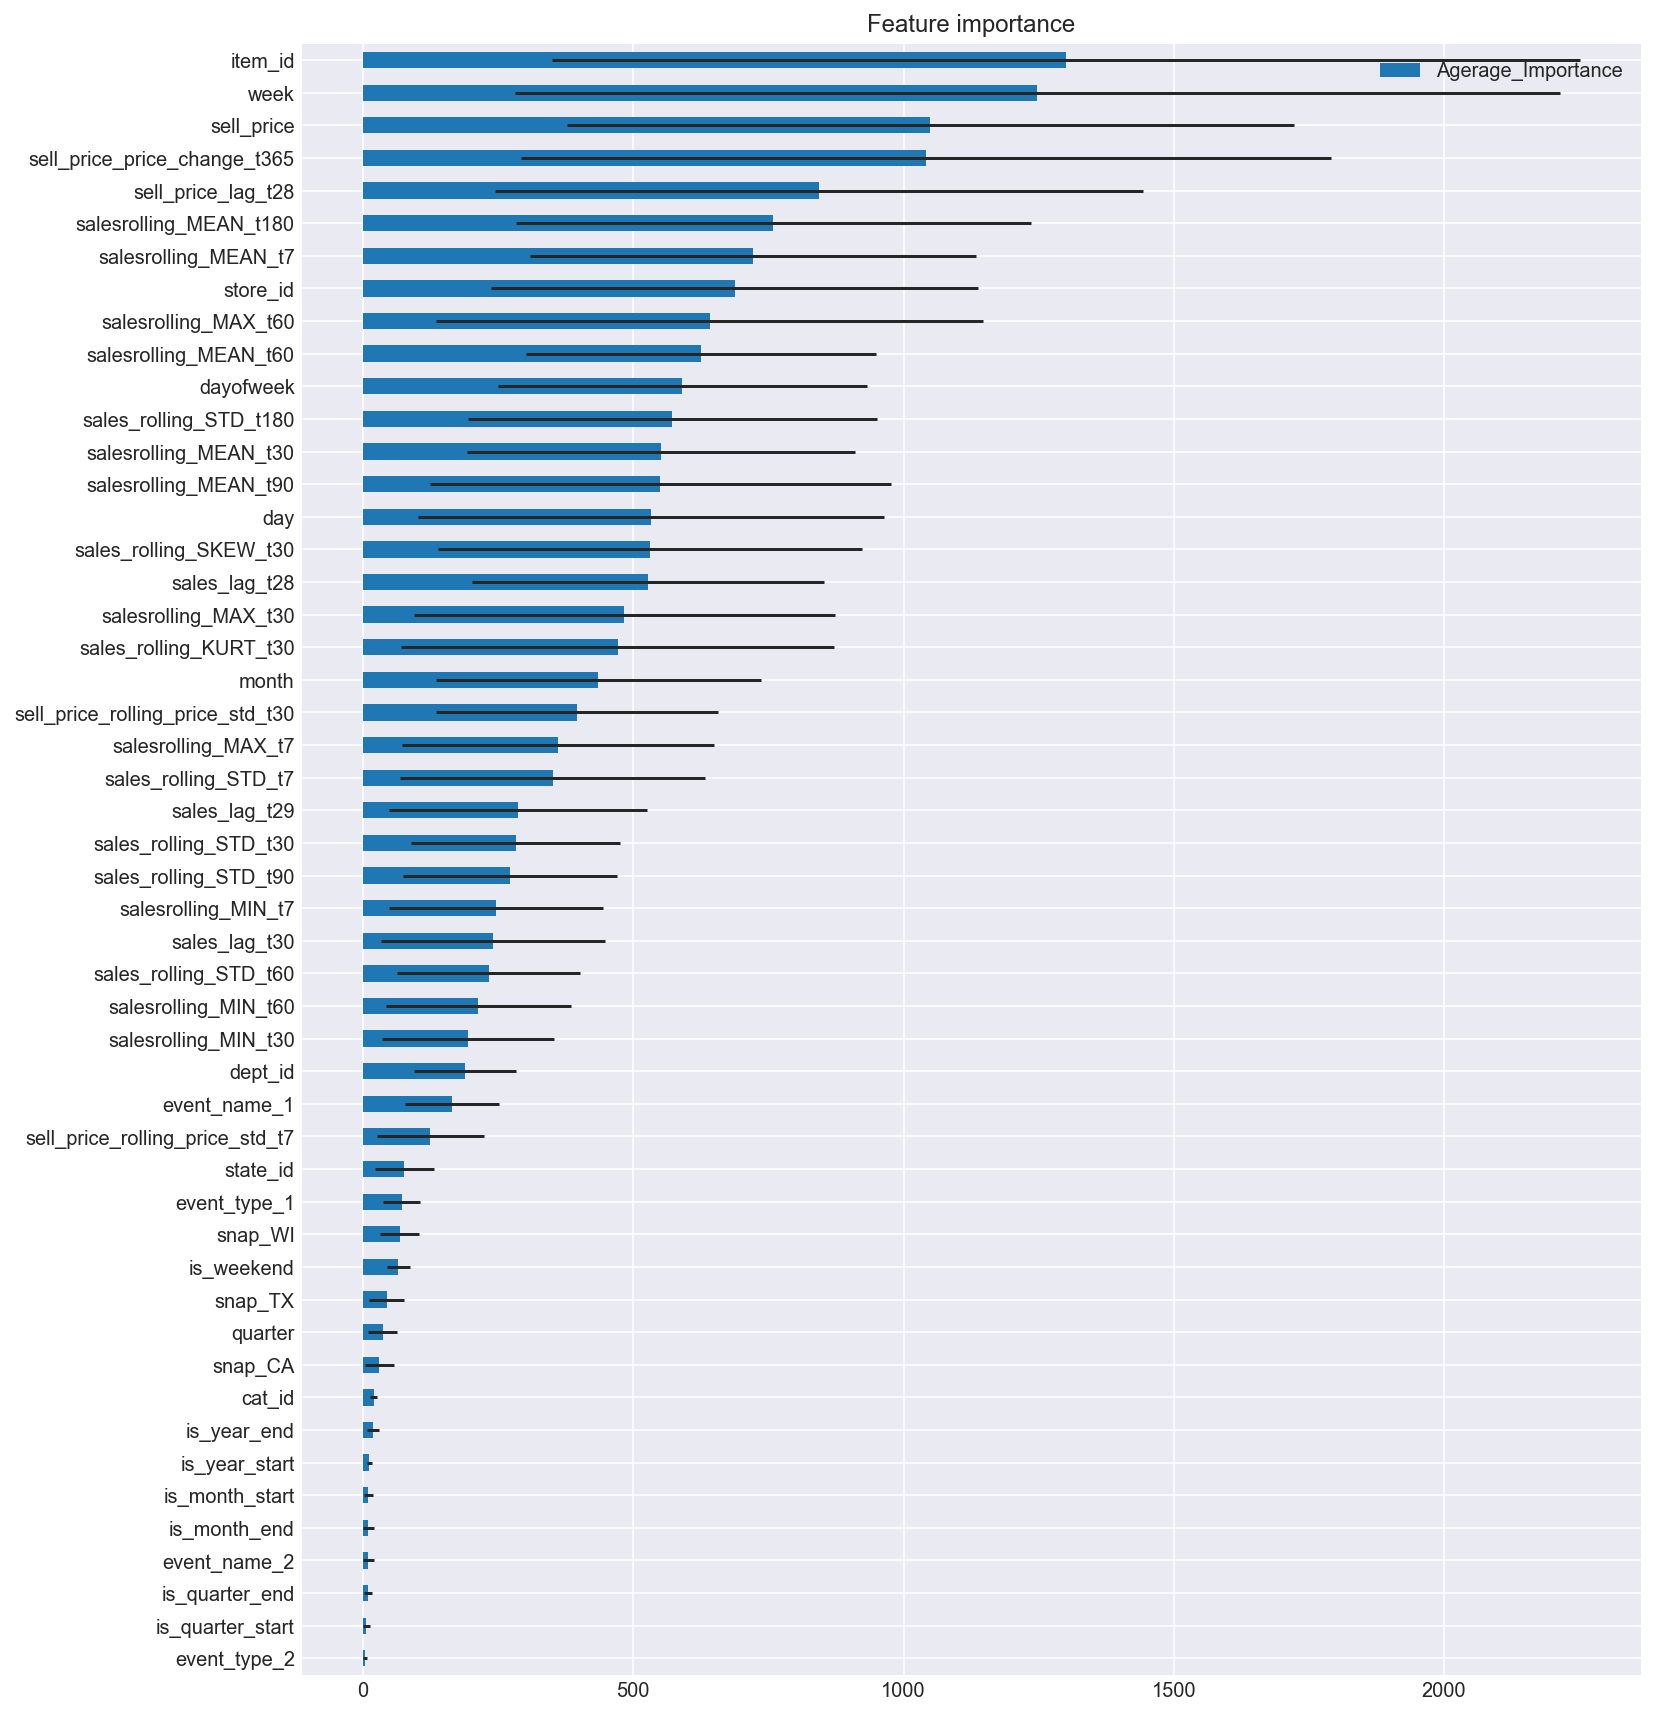

In [82]:
plot_importance(models)

## Evaluation

https://www.kaggle.com/konumaru/wrmsse-evaluator-with-extra-features?scriptVersionId=31249894

In [84]:
preds = np.mean([m.predict(X_eval.drop(['date', 'weight'], axis=1)) for m in models], axis=0)

In [85]:
from sklearn.metrics import mean_squared_error

rmse = mean_squared_error(y_eval.values, preds, squared=False)
print(f'RMSE: {rmse}')

rmsle = rmsele(preds, y_eval.values)
print(f'RMSLE: {rmsle}')

RMSE: 2.1828699740428528
RMSLE: 0.5622652189076764


In [93]:
from typing import Union

import numpy as np
import pandas as pd

class WRMSSEEvaluator(object):
    
    group_ids = ( 'all_id', 'state_id', 'store_id', 'cat_id', 'dept_id', 'item_id',
        ['state_id', 'cat_id'],  ['state_id', 'dept_id'], ['store_id', 'cat_id'],
        ['store_id', 'dept_id'], ['item_id', 'state_id'], ['item_id', 'store_id'])

    def __init__(self, 
                 train_df: pd.DataFrame, 
                 valid_df: pd.DataFrame, 
                 calendar: pd.DataFrame, 
                 prices: pd.DataFrame):
        '''
        intialize and calculate weights
        '''
        self.calendar = calendar
        self.prices = prices
        self.train_df = train_df
        self.valid_df = valid_df
        self.train_target_columns = [i for i in self.train_df.columns if i.startswith('d_')]
        self.weight_columns = self.train_df.iloc[:, -28:].columns.tolist()

        self.train_df['all_id'] = "all"

        self.id_columns = [i for i in self.train_df.columns if not i.startswith('d_')]
        self.valid_target_columns = [i for i in self.valid_df.columns if i.startswith('d_')]

        if not all([c in self.valid_df.columns for c in self.id_columns]):
            self.valid_df = pd.concat([self.train_df[self.id_columns], self.valid_df],
                                      axis=1, 
                                      sort=False)
        self.train_series = self.trans_30490_to_42840(self.train_df, 
                                                      self.train_target_columns, 
                                                      self.group_ids)
        self.valid_series = self.trans_30490_to_42840(self.valid_df, 
                                                      self.valid_target_columns, 
                                                      self.group_ids)
        self.weights = self.get_weight_df()
        self.scale = self.get_scale()
        self.train_series = None
        self.train_df = None
        self.prices = None
        self.calendar = None

    def get_scale(self):
        '''
        scaling factor for each series ignoring starting zeros
        '''
        scales = []
        for i in tqdm(range(len(self.train_series))):
            series = self.train_series.iloc[i].values
            series = series[np.argmax(series!=0):]
            scale = ((series[1:] - series[:-1]) ** 2).mean()
            scales.append(scale)
        return np.array(scales)
    
    def get_name(self, i):
        '''
        convert a str or list of strings to unique string 
        used for naming each of 42840 series
        '''
        if type(i) == str or type(i) == int:
            return str(i)
        else:
            return "--".join(i)
    
    def get_weight_df(self) -> pd.DataFrame:
        """
        returns weights for each of 42840 series in a dataFrame
        """
        day_to_week = self.calendar.set_index("d")["wm_yr_wk"].to_dict()
        weight_df = self.train_df[["item_id", "store_id"] + self.weight_columns].set_index(
            ["item_id", "store_id"]
        )
        weight_df = (
            weight_df.stack().reset_index().rename(columns={"level_2": "d", 0: "value"})
        )
        weight_df["wm_yr_wk"] = weight_df["d"].map(day_to_week)
        weight_df = weight_df.merge(
            self.prices, how="left", on=["item_id", "store_id", "wm_yr_wk"]
        )
        weight_df["value"] = weight_df["value"] * weight_df["sell_price"]
        weight_df = weight_df.set_index(["item_id", "store_id", "d"]).unstack(level=2)[
            "value"
        ]
        weight_df = weight_df.loc[
            zip(self.train_df.item_id, self.train_df.store_id), :
        ].reset_index(drop=True)
        weight_df = pd.concat(
            [self.train_df[self.id_columns], weight_df], axis=1, sort=False
        )
        weights_map = {}
        for i, group_id in enumerate(tqdm(self.group_ids, leave=False)):
            lv_weight = weight_df.groupby(group_id)[self.weight_columns].sum().sum(axis=1)
            lv_weight = lv_weight / lv_weight.sum()
            for i in range(len(lv_weight)):
                weights_map[self.get_name(lv_weight.index[i])] = np.array(
                    [lv_weight.iloc[i]]
                )
        weights = pd.DataFrame(weights_map).T / len(self.group_ids)

        return weights

    def trans_30490_to_42840(self, df, cols, group_ids, dis=False):
        '''
        transform 30490 sries to all 42840 series
        '''
        series_map = {}
        for i, group_id in enumerate(tqdm(self.group_ids, leave=False, disable=dis)):
            tr = df.groupby(group_id)[cols].sum()
            for i in range(len(tr)):
                series_map[self.get_name(tr.index[i])] = tr.iloc[i].values
        return pd.DataFrame(series_map).T
    
    def get_rmsse(self, valid_preds) -> pd.Series:
        '''
        returns rmsse scores for all 42840 series
        '''
        score = ((self.valid_series - valid_preds) ** 2).mean(axis=1)
        self.scale = np.where(self.scale != 0 , self.scale, 1)
        rmsse = (score / self.scale).map(np.sqrt)
        return rmsse

    def score(self, valid_preds: Union[pd.DataFrame, np.ndarray]) -> float:
        assert self.valid_df[self.valid_target_columns].shape == valid_preds.shape

        if isinstance(valid_preds, np.ndarray):
            valid_preds = pd.DataFrame(valid_preds, columns=self.valid_target_columns)

        valid_preds = pd.concat([self.valid_df[self.id_columns], valid_preds],
                                axis=1, 
                                sort=False)
        valid_preds = self.trans_30490_to_42840(valid_preds, 
                                                self.valid_target_columns, 
                                                self.group_ids, 
                                                True)
        self.rmsse = self.get_rmsse(valid_preds)
        self.contributors = pd.concat([self.weights, self.rmsse], 
                                      axis=1, 
                                      sort=False).prod(axis=1)
        return np.sum(self.contributors)

In [86]:
train_label_df = train[train_mask][['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id', 'd', 'sales']]
train_label_df['sales'] = train[train_mask][target_col].astype(int)

train_label_df = pd.pivot_table(train_label_df,
                                index = ['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'], 
                                columns = 'd', 
                                values = 'sales'
                ).reset_index()

def reverse_map(d):
    return {v: k for k, v in d.items()}

for label, encode_map in encode_maps.items():
    train_label_df[label] = train_label_df[label].map(reverse_map(encode_map))
    
fill_cols = train_label_df.columns[train_label_df.columns.str.startswith('d_')]
train_label_df[fill_cols] = train_label_df[fill_cols].fillna(0).astype(int)

fill_cols = sorted(fill_cols, key=lambda x:int((re.search(r"\d+", x)).group(0)))
cols = ['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'] + fill_cols
train_label_df[cols] = train_label_df[cols]

In [87]:
train_label_df.head()

d,id,item_id,dept_id,cat_id,store_id,state_id,d_1000,d_1001,d_1002,d_1003,...,d_990,d_991,d_992,d_993,d_994,d_995,d_996,d_997,d_998,d_999
0,FOODS_1_001_CA_1_validation,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,1,0,1,0,...,0,0,1,0,2,0,0,0,1,0
1,FOODS_1_001_CA_2_validation,FOODS_1_001,FOODS_1,FOODS,CA_2,CA,0,6,1,4,...,3,1,2,0,3,2,1,1,1,0
2,FOODS_1_001_CA_3_validation,FOODS_1_001,FOODS_1,FOODS,CA_3,CA,0,1,3,1,...,0,0,1,0,7,2,0,0,0,0
3,FOODS_1_001_CA_4_validation,FOODS_1_001,FOODS_1,FOODS,CA_4,CA,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,FOODS_1_001_TX_1_validation,FOODS_1_001,FOODS_1,FOODS,TX_1,TX,0,1,1,4,...,1,1,0,1,0,0,0,1,0,0


In [88]:
valid_label_df = train[eval_mask][['id', 'd']]
valid_label_df['sales'] = train[eval_mask][target_col]

valid_label_df = pd.pivot(valid_label_df, index = 'id', columns = 'd', values = 'sales').reset_index()
fill_cols = valid_label_df.columns[valid_label_df.columns.str.startswith('d_')]
valid_label_df[fill_cols] = valid_label_df[fill_cols].fillna(0).astype(int)

valid_label_df.drop('id', axis=1, inplace=True)

In [89]:
print(valid_label_df.shape)
valid_label_df.head()

(30490, 28)


d,d_1886,d_1887,d_1888,d_1889,d_1890,d_1891,d_1892,d_1893,d_1894,d_1895,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,2,1,1,0,4,0,0,4,1,3,...,0,2,0,4,1,1,0,1,1,0
1,0,0,0,0,0,0,0,1,1,2,...,1,0,14,0,1,1,4,0,0,4
2,0,0,1,0,0,1,0,0,0,1,...,0,0,13,0,0,0,0,0,1,0
3,2,0,0,0,0,0,0,1,0,1,...,0,0,0,2,0,0,0,1,1,1
4,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [90]:
valid_pred_df = train[eval_mask][['id', 'date']]
valid_pred_df['sales'] = preds

valid_pred_df = pd.pivot(valid_pred_df, index = 'id', columns = 'date', values = 'sales').reset_index()
# valid_pred_df.columns = ['id'] + ['F' + str(i + 1) for i in range(28)]
valid_pred_df.columns = ['id'] + valid_label_df.columns.tolist()
valid_pred_df.fillna(0, inplace=True)

valid_pred_df.drop('id', axis=1, inplace=True)

In [91]:
print(valid_pred_df.shape)
valid_pred_df.head()

(30490, 28)


,d_1886,d_1887,d_1888,d_1889,d_1890,d_1891,d_1892,d_1893,d_1894,d_1895,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,0.661023,0.623549,0.657462,0.622150,0.750484,0.918264,0.848111,0.609385,0.596579,0.580595,...,0.716156,0.964339,0.991257,0.628199,0.700323,0.764710,0.719170,0.810799,1.010169,0.925669
1,0.975231,1.035394,1.079136,1.059177,1.243022,1.848193,1.605772,1.211563,1.160659,1.088408,...,1.203990,1.485506,1.432801,0.999943,0.996602,0.976808,0.979106,1.065258,1.335400,1.288634
2,1.454116,1.402760,1.377263,1.341885,1.707232,1.942897,1.930057,1.537035,1.564682,1.518869,...,1.310308,1.502912,1.562136,1.266684,1.223724,1.218632,1.187959,1.208682,1.910753,1.484597
3,0.438401,0.440351,0.445557,0.446685,0.406504,0.417350,0.407684,0.535095,0.463129,0.444297,...,0.418749,0.470679,0.423446,0.379695,0.372872,0.410490,0.399298,0.393475,0.481266,0.445868
4,0.835413,0.928294,0.968958,0.973879,1.224702,1.402552,1.460608,1.019998,1.092132,1.048102,...,1.085992,1.268065,1.197698,0.936584,0.909060,0.920795,0.891318,1.000017,1.171087,1.122182


In [94]:
calendar = pd.read_pickle('../data/reduced/calendar.pkl')
sell_prices = pd.read_pickle('../data/reduced/sell_prices.pkl')
e = WRMSSEEvaluator(train_label_df, valid_label_df, calendar, sell_prices)

# del train_label_df, valid_label_df, calendar, sell_prices; gc.collect()

In [95]:
e.score(valid_pred_df)

0.7188280821083672

## Submission

In [97]:
sub_val_df = train[submit_mask][['id', 'date']]
sub_val_df['sales'] = np.mean([m.predict(X_submit.drop(['date', 'weight'], axis=1)) for m in models], axis=0)

sub_val_df = pd.pivot(sub_val_df, index = 'id', columns = 'date', values = 'sales').reset_index()
sub_val_df.columns = ['id'] + ['F' + str(i + 1) for i in range(28)]

In [98]:
sub_val_df.head()

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,FOODS_1_001_CA_1_validation,0.722857,0.707922,0.707052,0.702286,0.867357,1.039931,1.073980,0.851279,0.851143,...,0.925807,1.200068,1.091706,0.874519,0.847963,0.908176,0.814229,0.917972,1.150732,1.074322
1,FOODS_1_001_CA_2_validation,0.943297,0.943201,0.922004,0.903320,0.991155,1.219825,1.326499,0.891721,0.950459,...,0.911921,1.068289,1.433966,0.918654,0.896507,0.883570,1.105246,1.048377,1.245224,1.285310
2,FOODS_1_001_CA_3_validation,1.097741,1.038719,1.034907,1.055747,1.085303,1.252607,1.331849,1.119479,1.172865,...,1.128132,1.299312,1.865378,1.311776,1.238292,1.223594,1.223997,1.260230,1.510991,1.421297
3,FOODS_1_001_CA_4_validation,0.454561,0.437940,0.413574,0.415666,0.438522,0.491287,0.472623,0.438337,0.452248,...,0.389027,0.417520,0.400650,0.389643,0.379843,0.364419,0.363461,0.386506,0.449183,0.448193
4,FOODS_1_001_TX_1_validation,0.864336,0.870233,0.870781,0.872137,0.976339,1.168695,1.249046,0.958518,0.956646,...,1.088411,1.210008,1.248651,0.898402,0.884406,0.881494,0.879424,0.923937,1.076145,1.182215


In [100]:
sub_df = pd.DataFrame()
sub_df['id'] = submission['id']

sub_df = pd.merge(sub_df, sub_val_df, how='left', on='id')
sub_df.fillna(0, inplace=True)

print(sub_df.shape)
display(sub_df.head())

print('Export Submission File.')
sub_df.to_csv('submit/baseline.csv.gz', index=False, compression='gzip')

(60980, 29)


,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,HOBBIES_1_001_CA_1_validation,0.873383,0.751091,0.731750,0.706738,0.808257,1.019928,1.066171,0.802132,0.858149,...,0.960653,1.318306,1.248221,0.938920,0.837829,0.843352,0.922675,1.001978,1.260430,1.311398
1,HOBBIES_1_002_CA_1_validation,0.493426,0.428841,0.419997,0.410271,0.466430,0.540408,0.557738,0.430885,0.386000,...,0.366104,0.447682,0.446686,0.364510,0.333499,0.355459,0.342352,0.391980,0.456831,0.453042
2,HOBBIES_1_003_CA_1_validation,0.526240,0.481807,0.478251,0.480808,0.569775,0.766781,0.772484,0.579379,0.531550,...,0.653276,0.824133,0.917473,0.703004,0.678584,0.678864,0.628941,0.736041,0.946230,0.934932
3,HOBBIES_1_004_CA_1_validation,1.936190,1.622612,1.551165,1.443145,1.901478,2.263750,2.413911,1.798627,1.719887,...,1.986234,2.329899,2.533240,1.964343,1.711644,1.589397,1.600034,1.976888,2.824477,2.705836
4,HOBBIES_1_005_CA_1_validation,0.958930,0.845424,0.926262,1.016558,1.132543,1.477963,1.800303,1.237503,1.195689,...,1.143695,1.443852,1.426740,1.009634,0.934750,0.911661,0.930716,1.092058,1.457842,1.657549


Export Submission File.
